# Mestrado Prossional de Economia INSPER - Turma MPE16
# Trabalho de conclusão do curso de Finanças Quantitativas (2020.1)

#### Autores: Ciro Aloísio de Paula Duarte, João Italo Zecchin Reis, Robert Aldo Andreotti Filho 


#### O objetivo deste trabalho é criar uma estratégia de pair trading entre moedas de um mesmo bloco econômico, de modo que faça sentido a compração entre elas. Nossa proposta é usar os sinais de momentum, value e carry como critério de decisão para os negócios.

#### O relatório do trabalho está separado em três arquivos de Jupyter Notebook, onde esta é a primeira:
    Parte 1: Desenvolvimento dos trackers e dos sinais de momentum, value e carry das moedas analisadas contra o dólar.
    Parte 2: Criação da estratégia de trading.
    Parte 3: Realização do backtest.

Como fonte de dados usamos sempre dados extraídos da Bloomberg.

##  
## Parte 2

In [12]:
#import das bibliotecas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from bloomberg import BBG
bbg = BBG()

###   
#### Definição das moedas usadas na estratégia

In [13]:
#inicialização das listas dos blocos para evitar que em novas execuções do código possa ter lixo na memória
europe = []
cmdty = []
latam = []


#definição dos blocos de moedas em listas
europe = ['EUR', 'GBP', 'SEK']
cmdty = ['AUD', 'CAD', 'NOK', 'NZD']
latam = ['BRL', 'MXN']


basket = [europe, cmdty, latam]

#### Salvando os trackers e os sinais desenvolvidos na parte 1 do projeto paro uso neste Jupyter Notebook


In [14]:
mom_df = pd.read_excel('momentum.xlsx',index_col=0) #.fillna(method='ffill').dropna()
value_df = pd.read_excel('value.xlsx',index_col=0)
carry_df = pd.read_excel('carry.xlsx',index_col=0)
trackers_df = pd.read_excel('trackers.xlsx',index_col=0)


#### Criando o sinal

In [15]:
h = 21
# note the use of the .shift(-h) method below to make sure that on the index t we have the returns from t to t+h
returns_df = trackers_df.pct_change(h).shift(-h).dropna()
print('returns data has %s currencies and %s dates' % (returns_df.shape[1],returns_df.shape[0]))

returns data has 9 currencies and 2848 dates


In [16]:
import statsmodels.api as sm
signal = pd.DataFrame()
signal_knn = pd.DataFrame()

n = 5
for ccy in trackers_df.columns:
    print('Running currency %s' % ccy, end="\r")
    y = (1*(returns_df[ccy]>=0)).to_frame('returns')
    
    # get the three signals
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_mom = mom_df[ccy].dropna().to_frame('mom')
    X_value = value_df[ccy].dropna().to_frame('value')
    
    # make sure the signals are lined up and fill the nan's with the last obs in case there are some
    X = pd.concat([X_carry,X_mom,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    X = sm.add_constant(X)
    
    # make sure the dates of the signals and future returns line up
    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    
    
    X_with_interactions = PolynomialFeatures(interaction_only=True)
    X_with_interactions.fit_transform(X)
    features = X_with_interactions.get_feature_names(X.columns)
    features[0] = 'const'
    X_with_interactions = X_with_interactions.fit_transform(X)
    X_with_interactions = pd.DataFrame(index=X.index,data=X_with_interactions,columns=features).drop('const',1)
    yX_knn = pd.concat([y,X_with_interactions.shift(h).dropna()],axis=1,sort=True).dropna()
    
    neigh = KNeighborsClassifier(n_neighbors=n)    
    prob_market_going_up = pd.Series(index=yX.index[3*252:])
    prob_market_going_up_knn = pd.DataFrame()
    
    # loop over days
    for d in prob_market_going_up.index:
        # get past data for signal calculation
        past_returns_indicator = yX.iloc[:,0].loc[:d]
        past_features = yX.iloc[:,1:].loc[:d]
        past_returns_indicator_knn = yX_knn.iloc[:,0].loc[:d]
        past_features_knn = yX_knn.iloc[:,1:].loc[:d]
        
        # fit the model using Logit but do not use the last h observations to make sure we are using the right information set
        model = sm.Logit(past_returns_indicator.shift(h).dropna(), past_features.shift(h).dropna()).fit(disp=False)
        neigh.fit(past_features_knn, past_returns_indicator_knn)
        
        # now use current features to predict the market
        current_features = past_features.ewm(halflife=63).mean().iloc[-1] # note here the EWMA smoothing here
        current_features_knn = X_with_interactions.loc[:d].iloc[-1].values
        prob_market_going_up[d]= model.predict([current_features])[0]
        prob_market_going_up_knn[d] = neigh.predict_proba([current_features_knn])[0]
    
    signal = pd.concat([signal,prob_market_going_up.to_frame(ccy)],join='outer',axis=1,sort=True)
    signal_knn = pd.concat([signal_knn,prob_market_going_up_knn.iloc[1,:].to_frame(ccy)],join='outer',axis=1,sort=True)

signal = signal.fillna(method='ffill')

C:\Users\T709343\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\T709343\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\T709343\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\T709343\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\T709343\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\T709343\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\T709343\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\T709343\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


C:\Users\T709343\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [17]:
for ccy in trackers_df.columns:

    y = 1*(np.sign(returns_df[[ccy]])>=0)
    prediction = 1*(np.sign(signal[[ccy]] - 0.5)>0)
    prediction_knn = 1*(np.sign(signal_knn[[ccy]] - 0.5)>0)
    
    matriz = pd.concat([prediction,y],join='inner',axis=1,sort=True)
    print('A regressão logística está tendo os seguintes resultados:\nTrue positives = %s \nTrue negatives = %s \nFalse positives = %s \nFalse negatives = %s \n' %
          (confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,1),
           confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,0),
           confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,1),
           confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,0)))

    matriz = pd.concat([prediction_knn,y],join='inner',axis=1,sort=True)
    print('O classificador KNN com número de vizinhos igual a %s está tendo os seguintes resultados:\nTrue positives = %s \nTrue negatives = %s \nFalse positives = %s \nFalse negatives = %s \n' %
          (n,
           confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,1),
           confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,0),
           confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(0,1),
           confusion_matrix(matriz.iloc[:,0], matriz.iloc[:,1]).item(1,0)))

A regressão logística está tendo os seguintes resultados:
True positives = 259 
True negatives = 528 
False positives = 380 
False negatives = 414 

O classificador KNN com número de vizinhos igual a 5 está tendo os seguintes resultados:
True positives = 315 
True negatives = 595 
False positives = 324 
False negatives = 347 

A regressão logística está tendo os seguintes resultados:
True positives = 289 
True negatives = 430 
False positives = 434 
False negatives = 428 

O classificador KNN com número de vizinhos igual a 5 está tendo os seguintes resultados:
True positives = 390 
True negatives = 387 
False positives = 333 
False negatives = 471 

A regressão logística está tendo os seguintes resultados:
True positives = 266 
True negatives = 453 
False positives = 495 
False negatives = 367 

O classificador KNN com número de vizinhos igual a 5 está tendo os seguintes resultados:
True positives = 351 
True negatives = 489 
False positives = 410 
False negatives = 331 

A regressão l

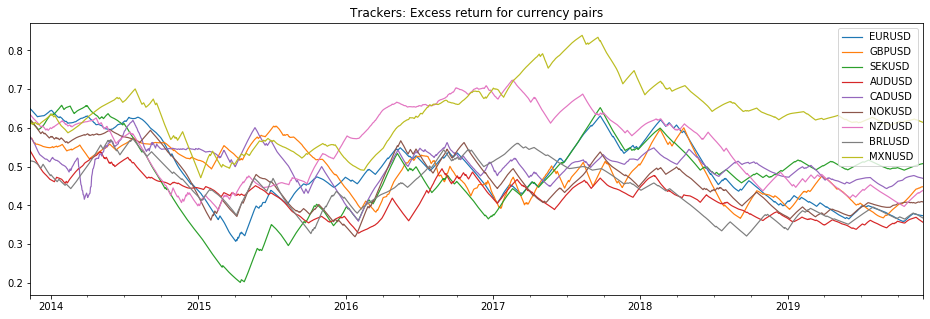

In [18]:
signal.plot(title='Trackers: Excess return for currency pairs',figsize=(16,5), linewidth=1.2)
plt.show()

##   
## Criando o backtest

In [19]:
#combinação dos pares entre si
pairs = []
for group in basket:
    pair_combiantions = list(itertools.combinations(group, 2))
    for i in range(len(pair_combiantions)):
        ccy1, ccy2 = pair_combiantions[i]
        pairs.append(ccy1+ccy2)

In [20]:
trackers_df = trackers_df.fillna(method='ffill')
backtest = pd.DataFrame(index=signal.index, columns = pairs)

for group in basket:  
    
    pair_combiantions = list(itertools.combinations(group, 2))
    for i in range(len(pair_combiantions)):
        ccy1, ccy2 = pair_combiantions[i]
        
        pair1 = ccy1+'USD'
        pair2 = ccy2+'USD'

        backtest[ccy1+ccy2].iloc[0] = 100 # initialize the backtest with 100
        start_date = signal.index[0]

        # first trade
        vols_ccy1 = np.log(trackers_df[pair1].loc[:start_date]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
        vols_ccy2 = np.log(trackers_df[pair2].loc[:start_date]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
        positions_ccy1 = 1*(signal[pair1].iloc[0] - signal[pair2].iloc[0]>0.05) + -1*(signal[pair2].iloc[0] - signal[pair1].iloc[0]>0.05)
        positions_ccy2 = -1*positions_ccy1
        prices_ccy1 = trackers_df[pair1].loc[:start_date].iloc[-1]
        prices_ccy2 = trackers_df[pair2].loc[:start_date].iloc[-1]
        holdings_ccy1 = ((0.4/vols_ccy1.iloc[-2])*positions_ccy1)*(backtest[ccy1+ccy2].iloc[0]/prices_ccy1)
        holdings_ccy2 = ((0.4/vols_ccy2.iloc[-2])*positions_ccy2)*(backtest[ccy1+ccy2].iloc[0]/prices_ccy2)
        if positions_ccy1 == -1:
            holdings_ccy2 = holdings_ccy1
        else:
            holdings_ccy1 = holdings_ccy2

        print('Running currency ' + ccy1 + ccy2, end="\r")

        # loop over the next days
        for i in range(1,len(signal)): # loop over all the signals
            tdy = signal[pair1].index[i]
            yst = signal[pair1].index[i-1]

            # calculate pnl on the day
            price_change_ccy1 = trackers_df[pair1].loc[:tdy].iloc[-1] - trackers_df[pair1].loc[:yst].iloc[-1]
            price_change_ccy2 = trackers_df[pair2].loc[:tdy].iloc[-1] - trackers_df[pair2].loc[:yst].iloc[-1]
            pnl_ccy1 = (holdings_ccy1*price_change_ccy1).mean()
            pnl_ccy2 = (holdings_ccy2*price_change_ccy2).mean()
            backtest[ccy1+ccy2].iloc[i] = backtest[ccy1+ccy2].iloc[i-1] + pnl_ccy1 + pnl_ccy2

            if tdy.week != yst.week: # check if it's a new week and reasses trades if so        
                vols_ccy1 = np.log(trackers_df[pair1].loc[:tdy]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
                vols_ccy2 = np.log(trackers_df[pair2].loc[:tdy]).diff(1).ewm(halflife=60).std()*np.sqrt(252)
                positions_ccy1 = 1*(-signal[pair1].iloc[i] + signal[pair2].iloc[i]>0.05) + -1*(-signal[pair2].iloc[i] + signal[pair1].iloc[i]>0.05)
                positions_ccy2 = -1*positions_ccy1
                prices_ccy1 = trackers_df[pair1].loc[:tdy].iloc[-1]
                prices_ccy2 = trackers_df[pair2].loc[:tdy].iloc[-1]
                holdings_ccy1 = ((0.4/vols_ccy1.iloc[-2])*positions_ccy1)*(backtest[ccy1+ccy2].iloc[i]/prices_ccy1)
                holdings_ccy2 = ((0.4/vols_ccy2.iloc[-2])*positions_ccy2)*(backtest[ccy1+ccy2].iloc[i]/prices_ccy2)
                if positions_ccy1 == -1:
                    holdings_ccy2 = holdings_ccy1
                else:
                    holdings_ccy1 = holdings_ccy2
                

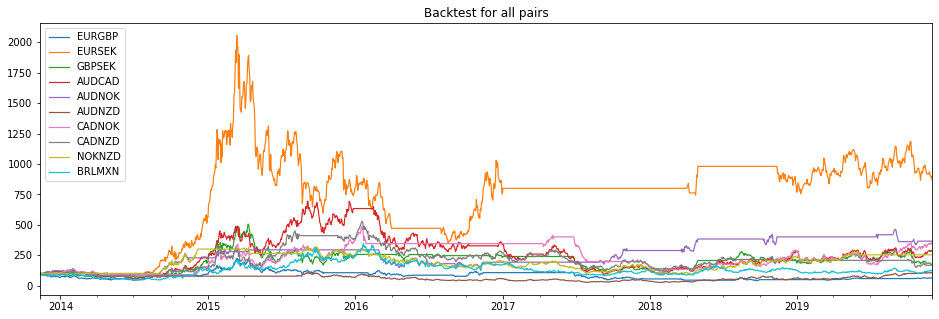

In [21]:
backtest.plot(title='Backtest for all pairs',figsize=(16,5), linewidth=1.2)
plt.show()

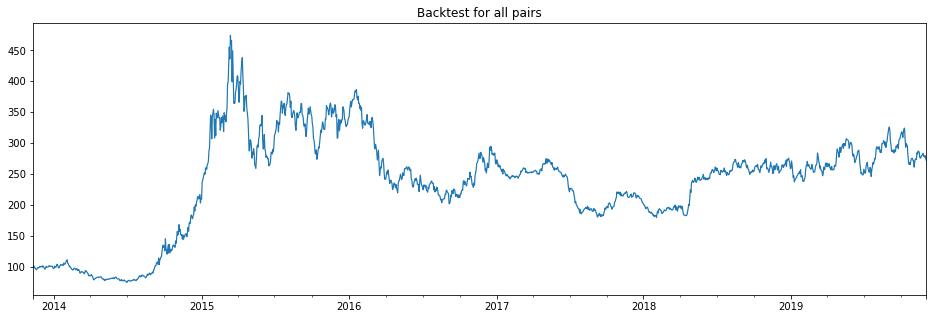

In [22]:
backtest['avg pnl'] = 0
for pair in pairs:
    backtest['avg pnl'] = backtest['avg pnl'] + backtest[pair]
backtest['avg pnl'] = backtest['avg pnl']/len(pairs)
backtest['avg pnl'].plot(title='Backtest for all pairs',figsize=(16,5), linewidth=1.2)
plt.show()
